<img src="https://ww2.ufps.edu.co/public/archivos/elementos_corporativos/logoufps.png" style="float: left; margin: 20px; height: 55px">  

<b> <font size='5'>  
HYBRID MODEL BASED ON ARTIFICIAL INTELLIGENCE FOR ENERGY DISPATCH IN A MICROGRID</font>  

<font size='4'> Forecast Regressor Demand Notebook</font> </b>

<font size='3'>  
&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; 2023<br>
</font>

---

In [13]:
#Import libraries

import Utils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')
plt.rcParams['font.sans-serif'] = ['Times New Roman']
plt.rcParams['font.serif'] = ['Times New Roman']
from sklearn.preprocessing import StandardScaler
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import grid_search_forecaster
from skforecast.utils import save_forecaster

In [14]:
#Load the dataset

datos = pd.read_csv('./3_Database.csv')
df = pd.DataFrame(datos)
df = df.drop(['index'],axis=1)

df.loc[df['Produccion FV (MW)'] < 0, 'Produccion FV (MW)'] = 0
df.loc[df['Produccion Eolica (MW)'] < 0, 'Produccion Eolica (MW)'] = 0
df.loc[df['Demanda (MW)'] < 0, 'Demanda (MW)'] = 0

reduccion = [0.2,0.2,0.06]

df['Produccion FV (MW)'] = df['Produccion FV (MW)']*reduccion[0]
df['Produccion Eolica (MW)'] = df['Produccion Eolica (MW)']*reduccion[1]
df['Demanda (MW)'] = df['Demanda (MW)']*reduccion[2]

In [15]:
#Adjust the index according to the time

df['Time'] = pd.to_datetime(df['Time'], format='%Y-%m-%d-T%H:%M')
df= df.set_index('Time')
df= df.asfreq('5min')
df= df.sort_index()

In [16]:
#Split data into train, validation and test

df = df.loc['2019-01-01 00:00': '2021-12-31 23:55']
fin_train = '2021-05-25 23:55'
fin_validacion = '2021-09-12 23:55'

data_train = df.loc[: fin_train, :]
data_val   = df.loc[fin_train:fin_validacion, :]
data_test  = df.loc[fin_validacion:, :]

print(f"Fechas train      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)}- 80%)")
print(f"Fechas validation : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)}- 10%)")
print(f"Fechas test       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)}- 10%)")

Fechas train      : 2019-01-01 00:00:00 --- 2021-05-25 23:55:00  (n=252288- 80%)
Fechas validation : 2021-05-25 23:55:00 --- 2021-09-12 23:55:00  (n=31681- 10%)
Fechas test       : 2021-09-12 23:55:00 --- 2021-12-31 23:55:00  (n=31681- 10%)


In [17]:
marker1 = plt.Line2D([0], [0], linestyle='none', marker='o', markersize=10, alpha=1.00,label="Test", color="blue")
marker2 = plt.Line2D([0], [0], linestyle='none', marker='o', markersize=10, alpha=1.00,label="Prediction", color="green")

<b> <font size='5'>SARIMA Model</font>

In [ ]:
#Entrenamiento del Forecaster

from skforecast.model_selection_statsmodels import grid_search_sarimax
df = df.resample(rule='H').mean()

param_grid = {'order': [(4, 1, 0),(0, 1, 3)],
                'seasonal_order': [(2, 1, 0, 24),(1, 1, 1, 24)],
                'trend': [None, 'n', 'c']}

results_grid = grid_search_sarimax(
                    y = df['Demanda (MW)'],
                    param_grid = param_grid,
                    initial_train_size = len(df[:fin_validacion]),
                    fixed_train_size = False,
                    steps = 7,
                    metric = 'mean_absolute_error',
                    refit = False,
                    verbose = False,
                    fit_kwargs = {'maxiter': 200, 'disp': 0},
                    exog = df[['Dia semana','Humedad','Temperatura']]
                )

results_grid

In [52]:
from skforecast.model_selection_statsmodels import backtesting_sarimax
df = df.resample(rule='H').mean()

metrica, predicciones_SARIMA = backtesting_sarimax(
                                        y = df['Demanda (MW)'],
                                        order = (0, 1, 3),
                                        seasonal_order = (1, 1, 1, 24),
                                        initial_train_size = len(df[:fin_validacion]),
                                        fixed_train_size = False,
                                        steps = 7,
                                        metric = 'mean_absolute_error',
                                        refit = False,
                                        verbose = True,
                                        fit_kwargs = {'maxiter': 250, 'disp': 0},
                                        exog = df[['Dia semana','Humedad','Temperatura']]
                                )

Number of observations used for training: 23664
Number of observations used for backtesting: 2640
    Number of folds: 378
    Number of steps per fold: 7
    Last fold only includes 1 observations.


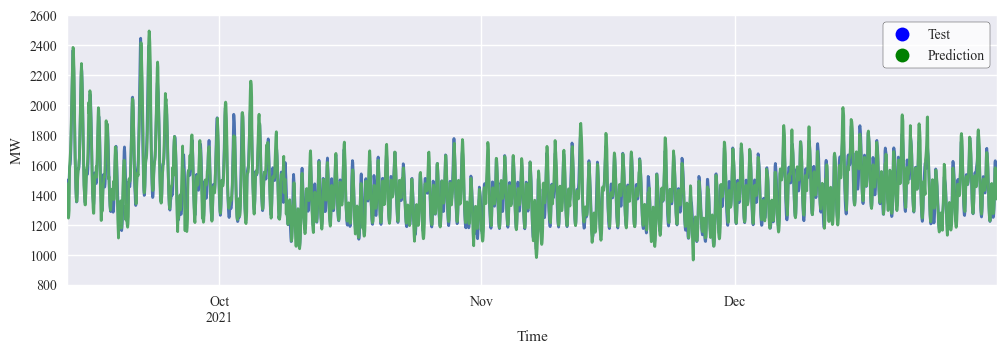

In [53]:
predicciones_SARIMA.loc[predicciones_SARIMA['predicted_mean'] < 0, 'predicted_mean'] = 0

fig, ax = plt.subplots(figsize=(12, 3.5))
df.loc[predicciones_SARIMA.index, 'Demanda (MW)'].plot(ax=ax, linewidth=2, label='Test')
predicciones_SARIMA['predicted_mean'].plot(linewidth=2, label='Predicción', ax=ax)
ax.set_ylim(800,2600)
ax.set_ylabel("MW")
ax.set_xlabel("Time")
ax.legend(handles=[marker1,marker2],frameon=True,edgecolor='black',facecolor='white')
plt.savefig('./Plots/Demand/SARIMA_Forecast.svg',bbox_inches='tight')

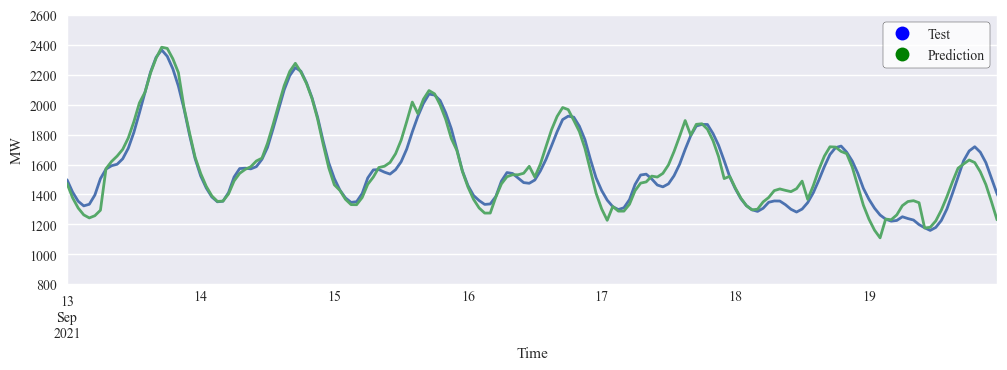

In [58]:
fig, ax = plt.subplots(figsize=(12, 3.5))
df.loc[predicciones_SARIMA.index, 'Demanda (MW)'].plot(ax=ax, linewidth=2, label='Test')
predicciones_SARIMA['predicted_mean'].plot(linewidth=2, label='Predicción', ax=ax)
ax.set_ylim(800,2600)
ax.set_ylabel("MW")
ax.set_xlabel("Time")
ax.legend(handles=[marker1,marker2],frameon=True,edgecolor='black',facecolor='white')
ax.set_xlim('2021-09-13 00:00','2021-09-19 23:55')
plt.savefig('./Plots/Demand/SARIMA_Forecast_with_zoom.svg',bbox_inches='tight')

In [55]:
from sklearn.metrics import mean_squared_error
predicciones_SARIMA = predicciones_SARIMA.rename(columns={'predicted_mean':'pred'})
data_test = data_test.resample(rule='H').mean()

mape = Utils.calculate_mape(predicciones_SARIMA,data_test,'Demanda (MW)')
data_test = data_test.iloc[:len(data_test)-1]
rmse = np.sqrt(mean_squared_error(y_true=data_test['Demanda (MW)'],y_pred=predicciones_SARIMA['pred']))

print('Error backtest: ')
print(f'MAE SARIMA: {metrica} MW')
print(f'MAPE SARIMA: {mape} %')
print(f'RMSE SARIMA: {rmse}')

Error backtest: 
MAE SARIMA: 41.59112717215006 MW
MAPE SARIMA: 2.8907306686559116 %
RMSE SARIMA: 80.57803326427009


<b> <font size='5'>Decision Tree Regressor Model</font>  

In [18]:
#Entrenamiento del Forecaster

from sklearn.tree import DecisionTreeRegressor

DT_forecaster = ForecasterAutoreg(
                regressor     = DecisionTreeRegressor(),
                lags          = 576,
                transformer_y = StandardScaler()
            )

DT_forecaster.fit(y=df.loc[:fin_validacion, 'Demanda (MW)'], exog = df[['Dia semana','Humedad','Temperatura']][:fin_validacion])
DT_forecaster

ForecasterAutoreg 
Regressor: DecisionTreeRegressor() 
Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 23

In [19]:
#Backtesting del Forecaster

metrica, predicciones_DT = backtesting_forecaster(
                            forecaster = DT_forecaster,
                            y          = df['Demanda (MW)'],
                            initial_train_size = len(df.loc[:fin_validacion]),
                            fixed_train_size   = False,
                            steps      = 576,
                            metric     = ['mean_absolute_error','mean_squared_error'],
                            refit      = False,
                            verbose    = True,
                            exog = df[['Dia semana','Humedad','Temperatura']]
                        )

Information of backtesting process
----------------------------------
Number of observations used for initial training: 283968
Number of observations used for backtesting: 31680
    Number of folds: 55
    Number of steps per fold: 576

Data partition in fold: 0
    Training:   2019-01-01 00:00:00 -- 2021-09-12 23:55:00  (n=283968)
    Validation: 2021-09-13 00:00:00 -- 2021-09-14 23:55:00  (n=576)
Data partition in fold: 1
    Training:   2019-01-01 00:00:00 -- 2021-09-12 23:55:00  (n=283968)
    Validation: 2021-09-15 00:00:00 -- 2021-09-16 23:55:00  (n=576)
Data partition in fold: 2
    Training:   2019-01-01 00:00:00 -- 2021-09-12 23:55:00  (n=283968)
    Validation: 2021-09-17 00:00:00 -- 2021-09-18 23:55:00  (n=576)
Data partition in fold: 3
    Training:   2019-01-01 00:00:00 -- 2021-09-12 23:55:00  (n=283968)
    Validation: 2021-09-19 00:00:00 -- 2021-09-20 23:55:00  (n=576)
Data partition in fold: 4
    Training:   2019-01-01 00:00:00 -- 2021-09-12 23:55:00  (n=283968)
    Va

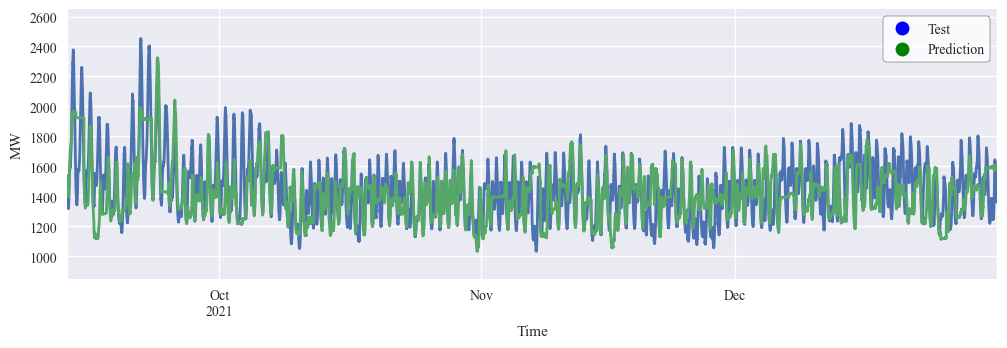

In [20]:
#Comparación de la predicción con respecto a los datos reales

fig, ax = plt.subplots(figsize=(12, 3.5))
df.loc[predicciones_DT.index, 'Demanda (MW)'].plot(ax=ax, linewidth=2, label='Test')
predicciones_DT.plot(linewidth=2, label='Predicción', ax=ax)
ax.set_ylim(850,2650)
ax.set_ylabel("MW")
ax.set_xlabel("Time")
ax.legend(handles=[marker1,marker2],frameon=True,edgecolor='black',facecolor='white')
plt.savefig('./Plots/Demand/DT_Forecast_before.svg',bbox_inches='tight')

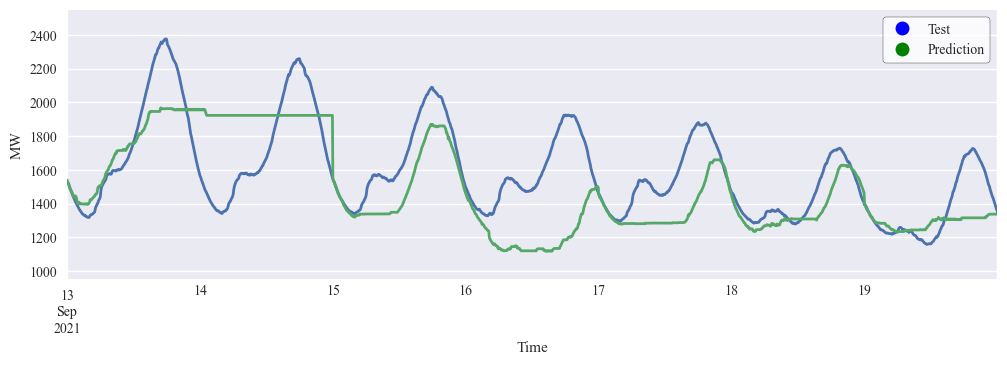

In [21]:
fig, ax = plt.subplots(figsize=(12, 3.5))
df.loc[predicciones_DT.index, 'Demanda (MW)'].plot(ax=ax, linewidth=2, label='Test')
predicciones_DT.plot(linewidth=2, label='Predicción', ax=ax)
ax.set_ylim(950,2550)
ax.set_ylabel("MW")
ax.set_xlabel("Time")
ax.legend(handles=[marker1,marker2],frameon=True,edgecolor='black',facecolor='white')
ax.set_xlim('2021-09-13 00:00','2021-09-19 23:55')
plt.savefig('./Plots/Demand/DT_Forecast_before_with_zoom.svg',bbox_inches='tight')

In [22]:
#Análisis de las métricas

mape = Utils.calculate_mape(predicciones_DT,data_test,'Demanda (MW)')
print('Error backtest: ')
print(f'MAE DT: {metrica[0]} MW')
print(f'MAPE DT: {mape} %')
print(f'RMSE DT: {np.sqrt(metrica[1])}')

Error backtest: 
MAE DT: 133.2530246212121 MW
MAPE DT: 9.07766389084529 %
RMSE DT: 183.4317347255698


In [23]:
#Hallando los hiperparámetros mediante tunning

DT_forecaster = ForecasterAutoreg(
                  regressor     = DecisionTreeRegressor(),
                  lags          = 576,
                  transformer_y = StandardScaler()# Este valor será remplazado en el grid search
            )

# Lags utilizados como predictores
lags_grid = [576]

# Hiperparámetros del regresor
param_grid = {
            'max_depth':[5,10],
            'min_samples_split':[30,50],
            'min_samples_leaf':[30,50],
            'max_features':[5,10]
            }

resultados_grid = grid_search_forecaster(
                        forecaster  = DT_forecaster,
                        y           = df.loc[:fin_validacion, 'Demanda (MW)'],
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 576,
                        metric      = ['mean_absolute_error','mean_squared_error'],
                        refit       = False,
                        initial_train_size = len(df[:fin_train]),
                        fixed_train_size   = False,
                        return_best = True,
                        verbose     = False,
                        exog = df[['Dia semana','Humedad','Temperatura']][:fin_validacion]
                  )

Number of models compared: 16.


loop lags_grid: 100%|██████████████████████████████████████| 1/1 [02:36<00:00, 156.72s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 22

In [24]:
resultados_grid

,lags,params,mean_absolute_error,mean_squared_error,max_depth,max_features,min_samples_leaf,min_samples_split
12,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'max_features': 10, 'min_sam...",133.645547,33910.827866,10,10,30,30
13,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'max_features': 10, 'min_sam...",142.121101,36928.619061,10,10,30,50
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'max_features': 5, 'min_sampl...",154.909141,40740.849793,5,5,30,50
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'max_features': 5, 'min_samp...",156.163872,46226.611142,10,5,50,30
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'max_features': 5, 'min_samp...",156.652119,45076.779436,10,5,30,50
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'max_features': 10, 'min_samp...",158.767054,40577.361086,5,10,30,30
14,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'max_features': 10, 'min_sam...",166.852404,51901.970935,10,10,50,30
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'max_features': 10, 'min_samp...",173.432923,52043.636381,5,10,50,50
15,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'max_features': 10, 'min_sam...",181.220212,62498.042257,10,10,50,50
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'max_features': 5, 'min_sampl...",186.404536,61813.780158,5,5,50,50


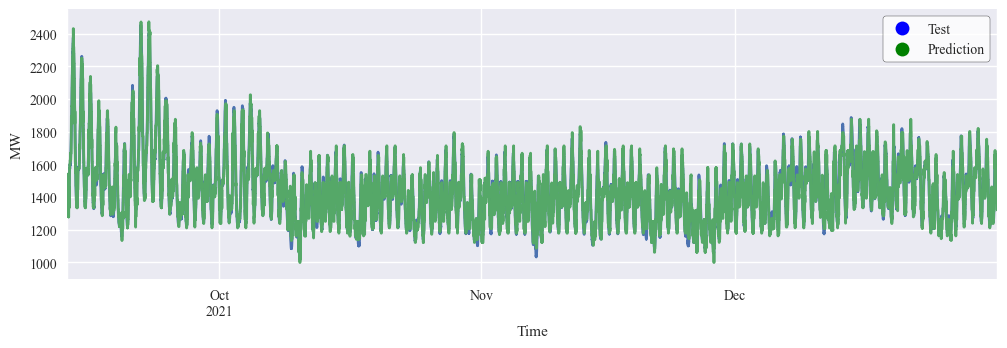

In [25]:
#Entrenamiento con nuevo modelo

metrica, predicciones_DT = backtesting_forecaster(
                            forecaster         = DT_forecaster,
                            y                  = df['Demanda (MW)'],
                            initial_train_size = len(df[:fin_validacion]),
                            fixed_train_size   = False,
                            steps              = 12,
                            metric             = ['mean_absolute_error','mean_squared_error'],
                            refit              = False,
                            verbose            = False,
                            exog = df[['Dia semana','Humedad','Temperatura']]
                        )

fig, ax = plt.subplots(figsize=(12, 3.5))
df.loc[predicciones_DT.index, 'Demanda (MW)'].plot(ax=ax, linewidth=2, label='Test')
predicciones_DT.plot(linewidth=2, label='Predicción', ax=ax)
ax.set_ylim(900,2550)
ax.set_ylabel("MW")
ax.set_xlabel("Time")
ax.legend(handles=[marker1,marker2],frameon=True,edgecolor='black',facecolor='white')
plt.savefig('./Plots/Demand/DT_Forecast_after.svg',bbox_inches='tight')

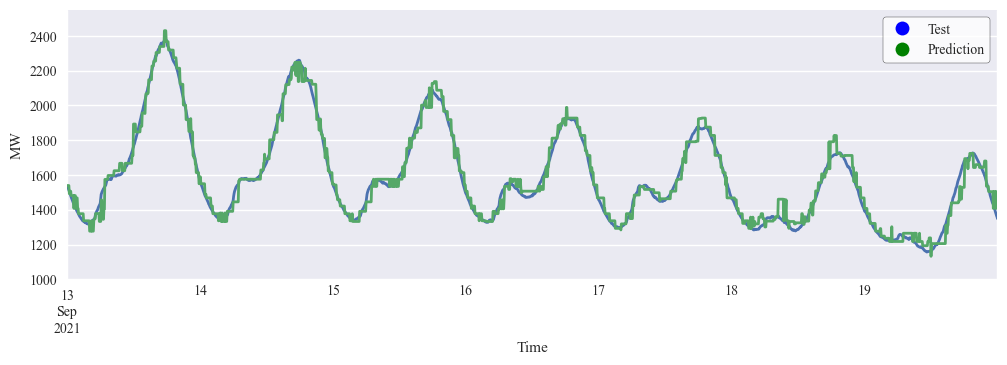

In [26]:
fig, ax = plt.subplots(figsize=(12, 3.5))
df.loc[predicciones_DT.index, 'Demanda (MW)'].plot(ax=ax, linewidth=2, label='Test')
predicciones_DT.plot(linewidth=2, label='Predicción', ax=ax)
ax.set_ylim(1000,2550)
ax.set_ylabel("MW")
ax.set_xlabel("Time")
ax.legend(handles=[marker1,marker2],frameon=True,edgecolor='black',facecolor='white')
ax.set_xlim('2021-09-13 00:00','2021-09-19 23:55')
plt.savefig('./Plots/Demand/DT_Forecast_after_with_zoom.svg',bbox_inches='tight')

In [27]:
#Análisis de las métricas

mape = Utils.calculate_mape(predicciones_DT,data_test,'Demanda (MW)')
print('Error backtest: ')
print(f'MAE DT: {metrica[0]} MW')
print(f'MAPE DT: {mape} %')
print(f'RMSE DT: {np.sqrt(metrica[1])}')

Error backtest: 
MAE DT: 31.60584941277952 MW
MAPE DT: 2.1987054801674035 %
RMSE DT: 43.80813778347182


In [28]:
#Save the model

save_forecaster(DT_forecaster, file_name='./Trained_models/DT_forecaster_Demand.py', verbose=False)

<b> <font size='5'>XGBoost Regressor Model</font>  

In [29]:
#Entrenamiento del Forecaster

from xgboost import XGBRegressor

XGB_forecaster = ForecasterAutoreg(
                regressor     = XGBRegressor(),
                lags          = 576,
                transformer_y = StandardScaler()
            )

XGB_forecaster.fit(y=df.loc[:fin_validacion, 'Demanda (MW)'], exog = df[['Dia semana','Humedad','Temperatura']][:fin_validacion])
XGB_forecaster

ForecasterAutoreg 
Regressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...) 
Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  5

In [30]:
#Backtesting del Forecaster

metrica, predicciones_XGB = backtesting_forecaster(
                            forecaster = XGB_forecaster,
                            y          = df['Demanda (MW)'],
                            initial_train_size = len(df.loc[:fin_validacion]),
                            fixed_train_size   = False,
                            steps      = 576,
                            metric     = ['mean_absolute_error','mean_squared_error'],
                            refit      = False,
                            verbose    = True,
                            exog = df[['Dia semana','Humedad','Temperatura']]
                        )

Information of backtesting process
----------------------------------
Number of observations used for initial training: 283968
Number of observations used for backtesting: 31680
    Number of folds: 55
    Number of steps per fold: 576

Data partition in fold: 0
    Training:   2019-01-01 00:00:00 -- 2021-09-12 23:55:00  (n=283968)
    Validation: 2021-09-13 00:00:00 -- 2021-09-14 23:55:00  (n=576)
Data partition in fold: 1
    Training:   2019-01-01 00:00:00 -- 2021-09-12 23:55:00  (n=283968)
    Validation: 2021-09-15 00:00:00 -- 2021-09-16 23:55:00  (n=576)
Data partition in fold: 2
    Training:   2019-01-01 00:00:00 -- 2021-09-12 23:55:00  (n=283968)
    Validation: 2021-09-17 00:00:00 -- 2021-09-18 23:55:00  (n=576)
Data partition in fold: 3
    Training:   2019-01-01 00:00:00 -- 2021-09-12 23:55:00  (n=283968)
    Validation: 2021-09-19 00:00:00 -- 2021-09-20 23:55:00  (n=576)
Data partition in fold: 4
    Training:   2019-01-01 00:00:00 -- 2021-09-12 23:55:00  (n=283968)
    Va

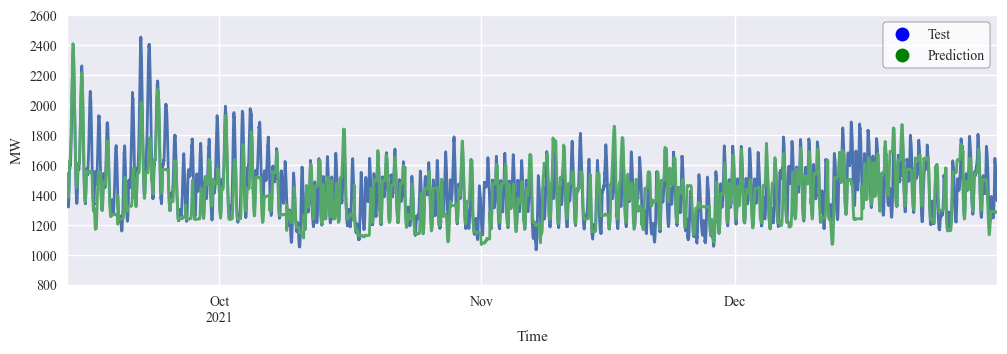

In [31]:
#Comparación de la predicción con respecto a los datos reales

fig, ax = plt.subplots(figsize=(12, 3.5))
df.loc[predicciones_XGB.index, 'Demanda (MW)'].plot(ax=ax, linewidth=2, label='Test')
predicciones_XGB.plot(linewidth=2, label='Predicción', ax=ax)
ax.set_ylim(800,2600)
ax.set_ylabel("MW")
ax.set_xlabel("Time")
ax.legend(handles=[marker1,marker2],frameon=True,edgecolor='black',facecolor='white')
plt.savefig('./Plots/Demand/XGB_Forecast_before.svg',bbox_inches='tight')

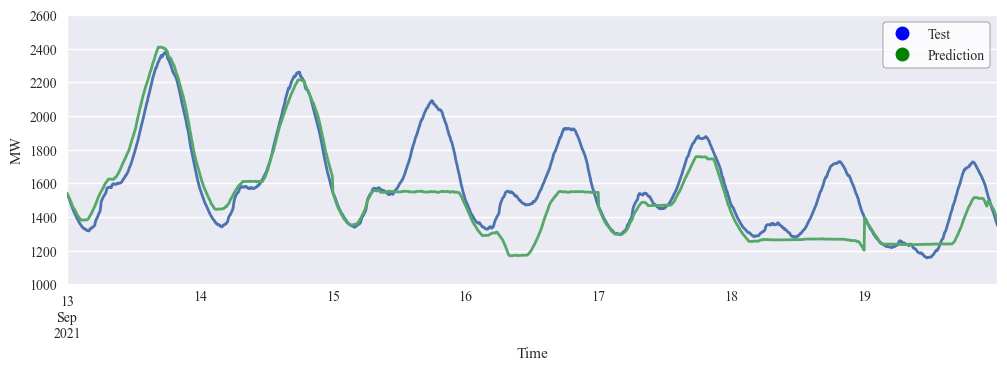

In [32]:
fig, ax = plt.subplots(figsize=(12, 3.5))
df.loc[predicciones_XGB.index, 'Demanda (MW)'].plot(ax=ax, linewidth=2, label='Test')
predicciones_XGB.plot(linewidth=2, label='Predicción', ax=ax)
ax.set_ylim(1000,2600)
ax.set_ylabel("MW")
ax.set_xlabel("Time")
ax.legend(handles=[marker1,marker2],frameon=True,edgecolor='black',facecolor='white')
ax.set_xlim('2021-09-13 00:00','2021-09-19 23:55')
plt.savefig('./Plots/Demand/XGB_Forecast_before_with_zoom.svg',bbox_inches='tight')

In [33]:
#Análisis de las métricas

mape = Utils.calculate_mape(predicciones_XGB,data_test,'Demanda (MW)')
print('Error backtest: ')
print(f'MAE XGB: {metrica[0]} MW')
print(f'MAPE XGB: {mape} %')
print(f'RMSE XGB: {np.sqrt(metrica[1])}')

Error backtest: 
MAE XGB: 105.48111501910427 MW
MAPE XGB: 7.063161947102719 %
RMSE XGB: 153.12153757282007


In [34]:
#Hallando los hiperparámetros mediante tunning

XGB_forecaster = ForecasterAutoreg(
                        regressor     = XGBRegressor(),
                        lags          = 576,
                        transformer_y = StandardScaler()# Este valor será remplazado en el grid search
                )

# Lags utilizados como predictores
lags_grid = [576]

# Hiperparámetros del regresor
param_grid = {
                'learning_rate':[0.1,0.3],
                'n_estimators':[50,200],
                'max_depth':[3,5]
                }

resultados_grid = grid_search_forecaster(
                        forecaster  = XGB_forecaster,
                        y           = df.loc[:fin_validacion, 'Demanda (MW)'],
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 576,
                        metric      = ['mean_absolute_error','mean_squared_error'],
                        refit       = False,
                        initial_train_size = len(df[:fin_train]),
                        fixed_train_size   = False,
                        return_best = True,
                        verbose     = False,
                        exog = df[['Dia semana','Humedad','Temperatura']][:fin_validacion]
                )

Number of models compared: 8.


loop lags_grid: 100%|█████████████████████████████████████| 1/1 [56:16<00:00, 3376.13s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 22

In [35]:
resultados_grid

,lags,params,mean_absolute_error,mean_squared_error,learning_rate,max_depth,n_estimators
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",70.639569,9595.180333,0.1,5.0,200.0
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",121.520065,25679.393281,0.1,5.0,50.0
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.3, 'max_depth': 5, 'n_esti...",167.197341,59173.282493,0.3,5.0,200.0
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.3, 'max_depth': 3, 'n_esti...",179.912486,63369.683682,0.3,3.0,200.0
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",187.944169,66882.604132,0.1,3.0,200.0
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",221.301821,79815.444211,0.1,3.0,50.0
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.3, 'max_depth': 3, 'n_esti...",230.835023,82743.592372,0.3,3.0,50.0
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.3, 'max_depth': 5, 'n_esti...",282.944863,147112.038682,0.3,5.0,50.0


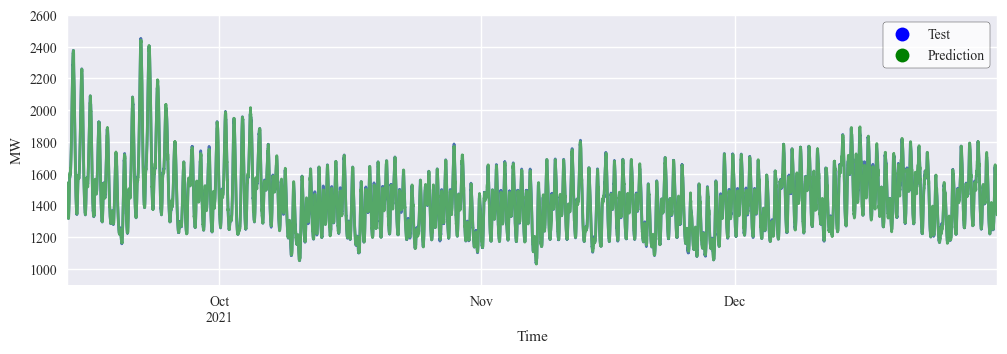

In [36]:
#Entrenamiento con nuevo modelo

metrica, predicciones_XGB = backtesting_forecaster(
                            forecaster         = XGB_forecaster,
                            y                  = df['Demanda (MW)'],
                            initial_train_size = len(df[:fin_validacion]),
                            fixed_train_size   = False,
                            steps              = 12,
                            metric             = ['mean_absolute_error','mean_squared_error'],
                            refit              = False,
                            verbose            = False,
                            exog = df[['Dia semana','Humedad','Temperatura']]
                        )

fig, ax = plt.subplots(figsize=(12, 3.5))
df.loc[predicciones_XGB.index, 'Demanda (MW)'].plot(ax=ax, linewidth=2, label='Test')
predicciones_XGB.plot(linewidth=2, label='Predicción', ax=ax)
ax.set_ylim(900,2600)
ax.set_ylabel("MW")
ax.set_xlabel("Time")
ax.legend(handles=[marker1,marker2],frameon=True,edgecolor='black',facecolor='white')
plt.savefig('./Plots/Demand/XGB_Forecast_after.svg',bbox_inches='tight')

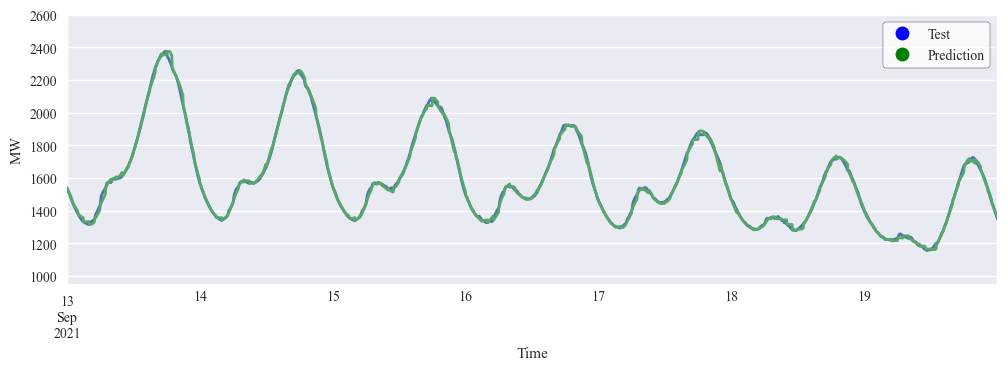

In [37]:
fig, ax = plt.subplots(figsize=(12, 3.5))
df.loc[predicciones_XGB.index, 'Demanda (MW)'].plot(ax=ax, linewidth=2, label='Test')
predicciones_XGB.plot(linewidth=2, label='Predicción', ax=ax)
ax.set_ylim(950,2600)
ax.set_ylabel("MW")
ax.set_xlabel("Time")
ax.legend(handles=[marker1,marker2],frameon=True,edgecolor='black',facecolor='white')
ax.set_xlim('2021-09-13 00:00','2021-09-19 23:55')
plt.savefig('./Plots/Demand/XGB_Forecast_after_with_zoom.svg',bbox_inches='tight')

In [38]:
#Análisis de las métricas

mape = Utils.calculate_mape(predicciones_XGB,data_test,'Demanda (MW)')
print('Error backtest: ')
print(f'MAE XGB: {metrica[0]} MW')
print(f'MAPE XGB: {mape} %')
print(f'RMSE XGB: {np.sqrt(metrica[1])}')

Error backtest: 
MAE XGB: 9.091541892034435 MW
MAPE XGB: 0.621512235063119 %
RMSE XGB: 12.836259576736852


In [39]:
#Save the model

save_forecaster(XGB_forecaster, file_name='./Trained_models/XGB_forecaster_Demand.py', verbose=False)

<b> <font size='5'>Multi Linear Regression Model</font>  

In [40]:
#Entrenamiento del Forecaster

from sklearn.linear_model import LinearRegression

LR_forecaster = ForecasterAutoreg(
                regressor     = LinearRegression(),
                lags          = 576,
                transformer_y = StandardScaler()
            )

LR_forecaster.fit(y=df.loc[:fin_validacion, 'Demanda (MW)'],exog = df[['Dia semana','Humedad','Temperatura']][:fin_validacion])
LR_forecaster

ForecasterAutoreg 
Regressor: LinearRegression() 
Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233

In [41]:
#Backtesting del Forecaster

metrica, predicciones_LR = backtesting_forecaster(
                            forecaster = LR_forecaster,
                            y          = df['Demanda (MW)'],
                            initial_train_size = len(df.loc[:fin_validacion]),
                            fixed_train_size   = False,
                            steps      = 576,
                            metric     = ['mean_absolute_error','mean_squared_error'],
                            refit      = False,
                            verbose    = True,
                            exog = df[['Dia semana','Humedad','Temperatura']]
                        )

Information of backtesting process
----------------------------------
Number of observations used for initial training: 283968
Number of observations used for backtesting: 31680
    Number of folds: 55
    Number of steps per fold: 576

Data partition in fold: 0
    Training:   2019-01-01 00:00:00 -- 2021-09-12 23:55:00  (n=283968)
    Validation: 2021-09-13 00:00:00 -- 2021-09-14 23:55:00  (n=576)
Data partition in fold: 1
    Training:   2019-01-01 00:00:00 -- 2021-09-12 23:55:00  (n=283968)
    Validation: 2021-09-15 00:00:00 -- 2021-09-16 23:55:00  (n=576)
Data partition in fold: 2
    Training:   2019-01-01 00:00:00 -- 2021-09-12 23:55:00  (n=283968)
    Validation: 2021-09-17 00:00:00 -- 2021-09-18 23:55:00  (n=576)
Data partition in fold: 3
    Training:   2019-01-01 00:00:00 -- 2021-09-12 23:55:00  (n=283968)
    Validation: 2021-09-19 00:00:00 -- 2021-09-20 23:55:00  (n=576)
Data partition in fold: 4
    Training:   2019-01-01 00:00:00 -- 2021-09-12 23:55:00  (n=283968)
    Va

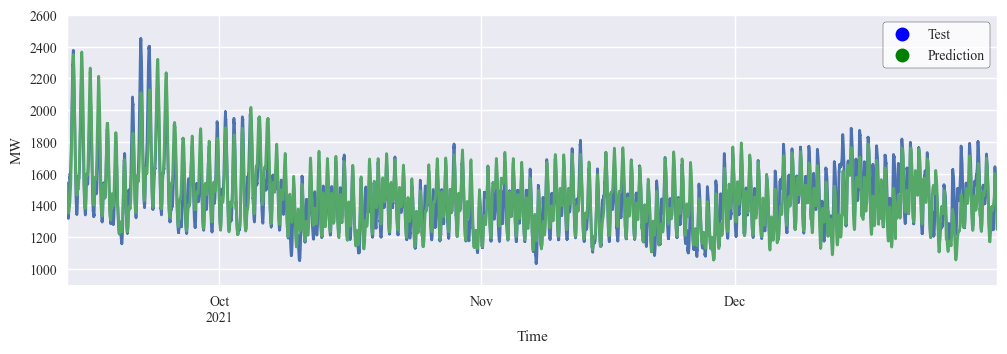

In [42]:
#Comparación de la predicción con respecto a los datos reales

predicciones_LR.loc[predicciones_LR['pred'] < 0, 'pred'] = 0
fig, ax = plt.subplots(figsize=(12, 3.5))
df.loc[predicciones_LR.index, 'Demanda (MW)'].plot(ax=ax, linewidth=2, label='Test')
predicciones_LR.plot(linewidth=2, label='Predicción', ax=ax)
ax.set_ylim(900,2600)
ax.set_ylabel("MW")
ax.set_xlabel("Time")
ax.legend(handles=[marker1,marker2],frameon=True,edgecolor='black',facecolor='white')
plt.savefig('./Plots/Demand/LR_Forecast_before.svg',bbox_inches='tight')

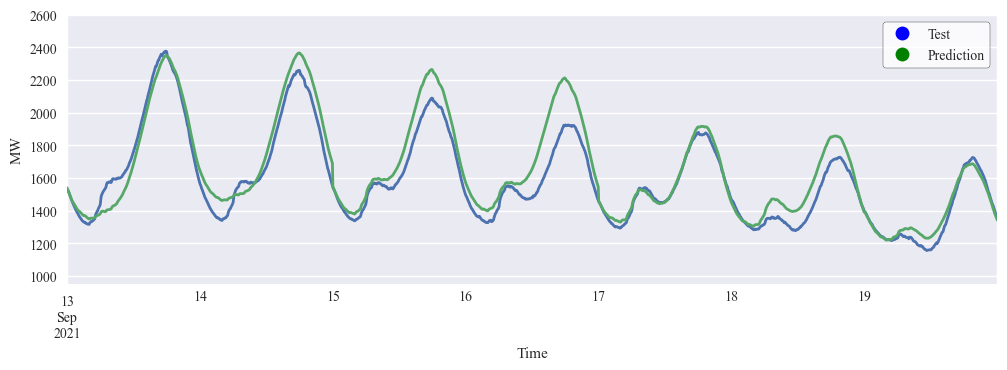

In [43]:
fig, ax = plt.subplots(figsize=(12, 3.5))
df.loc[predicciones_LR.index, 'Demanda (MW)'].plot(ax=ax, linewidth=2, label='Test')
predicciones_LR.plot(linewidth=2, label='Predicción', ax=ax)
ax.set_ylim(950,2600)
ax.set_ylabel("MW")
ax.set_xlabel("Time")
ax.legend(handles=[marker1,marker2],frameon=True,edgecolor='black',facecolor='white')
ax.set_xlim('2021-09-13 00:00','2021-09-19 23:55')
plt.savefig('./Plots/Demand/LR_Forecast_before_with_zoom.svg',bbox_inches='tight')

In [44]:
#Análisis de las métricas

mape = Utils.calculate_mape(predicciones_LR,data_test,'Demanda (MW)')
print('Error backtest: ')
print(f'MAE LR: {metrica[0]} MW')
print(f'MAPE LR: {mape} %')
print(f'RMSE LR: {np.sqrt(metrica[1])}')

Error backtest: 
MAE LR: 68.3146613287262 MW
MAPE LR: 4.665178177863837 %
RMSE LR: 94.2631902297583


In [45]:
#Hallando los hiperparámetros mediante tunning

LR_forecaster = ForecasterAutoreg(
                    regressor     = LinearRegression(),
                    lags          = 576,
                    transformer_y = StandardScaler()# Este valor será remplazado en el grid search
            )

# Lags utilizados como predictores
lags_grid = [576]

param_grid = {
            'fit_intercept':[True,False],
            'n_jobs':[None,-1]
            }

resultados_grid = grid_search_forecaster(
                        forecaster  = LR_forecaster,
                        y           = df.loc[:fin_validacion, 'Demanda (MW)'],
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 576,
                        metric      = ['mean_absolute_error','mean_squared_error'],
                        refit       = False,
                        initial_train_size = len(df[:fin_train]),
                        fixed_train_size   = False,
                        return_best = True,
                        verbose     = False,
                        exog = df[['Dia semana','Humedad','Temperatura']][:fin_validacion]
                    )

Number of models compared: 4.


loop lags_grid: 100%|██████████████████████████████████████| 1/1 [02:48<00:00, 168.29s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 22

In [46]:
resultados_grid

,lags,params,mean_absolute_error,mean_squared_error,fit_intercept,n_jobs
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'fit_intercept': False, 'n_jobs': None}",77.633005,11304.313193,False,NaN
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'fit_intercept': False, 'n_jobs': -1}",77.633005,11304.313193,False,-1.0
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'fit_intercept': True, 'n_jobs': None}",77.717310,11330.865516,True,NaN
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'fit_intercept': True, 'n_jobs': -1}",77.717310,11330.865516,True,-1.0


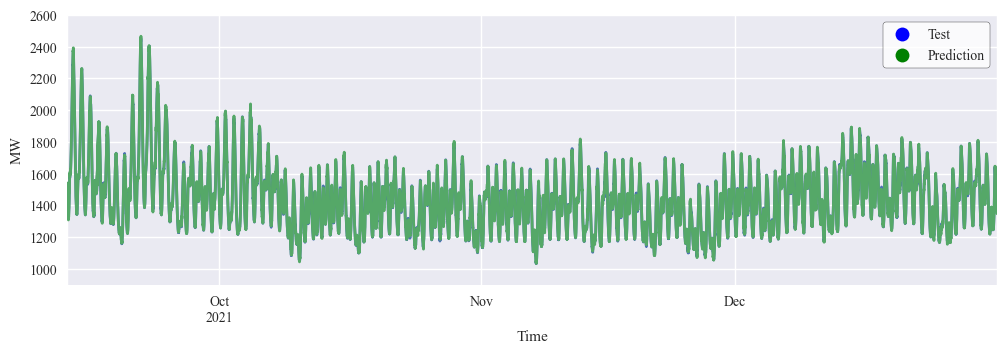

In [47]:
#Entrenamiento con nuevo modelo

metrica, predicciones_LR = backtesting_forecaster(
                            forecaster         = LR_forecaster,
                            y                  = df['Demanda (MW)'],
                            initial_train_size = len(df[:fin_validacion]),
                            fixed_train_size   = False,
                            steps              = 12,
                            metric             = ['mean_absolute_error','mean_squared_error'],
                            refit              = False,
                            verbose            = False,
                            exog = df[['Dia semana','Humedad','Temperatura']]
                        )

predicciones_LR.loc[predicciones_LR['pred'] < 0, 'pred'] = 0
fig, ax = plt.subplots(figsize=(12, 3.5))
df.loc[predicciones_LR.index, 'Demanda (MW)'].plot(ax=ax, linewidth=2, label='Test')
predicciones_LR.plot(linewidth=2, label='Predicción', ax=ax)
ax.set_ylim(900,2600)
ax.set_ylabel("MW")
ax.set_xlabel("Time")
ax.legend(handles=[marker1,marker2],frameon=True,edgecolor='black',facecolor='white')
plt.savefig('./Plots/Demand/LR_Forecast_after.svg',bbox_inches='tight')

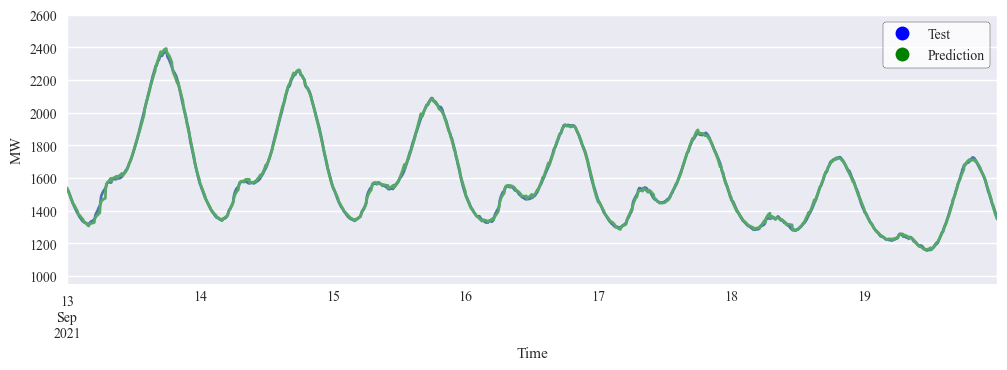

In [48]:
fig, ax = plt.subplots(figsize=(12, 3.5))
df.loc[predicciones_LR.index, 'Demanda (MW)'].plot(ax=ax, linewidth=2, label='Test')
predicciones_LR.plot(linewidth=2, label='Predicción', ax=ax)
ax.set_ylim(950,2600)
ax.set_ylabel("MW")
ax.set_xlabel("Time")
ax.legend(handles=[marker1,marker2],frameon=True,edgecolor='black',facecolor='white')
ax.set_xlim('2021-09-13 00:00','2021-09-19 23:55')
plt.savefig('./Plots/Demand/LR_Forecast_after_with_zoom.svg',bbox_inches='tight')

In [49]:
#Análisis de las métricas

mape = Utils.calculate_mape(predicciones_LR,data_test,'Demanda (MW)')
print('Error backtest: ')
print(f'MAE LR: {metrica[0]} MW')
print(f'MAPE LR: {mape} %')
print(f'RMSE LR: {np.sqrt(metrica[1])}')

Error backtest: 
MAE LR: 7.073582226355669 MW
MAPE LR: 0.4931631882835419 %
RMSE LR: 10.279900511105085


In [50]:
#Save the model

save_forecaster(LR_forecaster, file_name='./Trained_models/LR_forecaster_Demand.py', verbose=False)

<b> <font size='5'>Saving all the models</font>  

In [56]:
predicciones_SARIMA.to_csv('./Predictions/Demand/SARIMA_predictions.csv')
predicciones_DT.to_csv('./Predictions/Demand/DT_predictions.csv')
predicciones_XGB.to_csv('./Predictions/Demand/XGB_predictions.csv')
predicciones_LR.to_csv('./Predictions/Demand/LR_predictions.csv')